## Feature to Phenotype
* Given a list of features produced by the GENIE_Analysis notebook
* Fetch phenotypes for each variant
* Filter to only the phenotypes found by `cgi`
* Plot a simple summary

In [2]:
from g2p_client import G2PDatabase
from __future__ import division
import pandas as pd


In [3]:
# from the GENIE_Analysis notebook
# grouped_evidence_df.to_pickle("grouped_evidence_df.pkl")
grouped_evidence_df = pd.read_pickle("grouped_evidence_df.pkl")
INDEX = 'associations'
HOST = 'elastic'
DATABASE = G2PDatabase(HOST, INDEX)

In [4]:
# structure of existing dataset
print len(grouped_evidence_df)
grouped_evidence_df.head()

8262


,feature_chromosome,feature_start,feature_ref,feature_alt,source,evidence_label,evidence_count
23,1,8073509,C,A,civic,C,1
26,1,11169361,C,G,cgi,D,1
27,1,11174420,C,T,cgi,C,1
29,1,11177096,C,A,civic,D,3
30,1,11182158,A,C,oncokb,D,1


### Lookup phenotype counts for each feature
* denormalize into a new data frame

In [5]:
def add_phenotypes(df):
    """iterate through df. denormalize, create new row for each phenotype """
    for index, row  in df.iterrows():
        phenotypes = DATABASE.feature_to_phenotypes(row)
        for phenotype in phenotypes:        
            phenotype.update(row)
            yield phenotype

# create new dataframe, note that feature rows are duplicated for each matched phenotype            
grouped_evidence_phenotypes_df = pd.DataFrame(add_phenotypes(grouped_evidence_df))
# save for analysis
grouped_evidence_phenotypes_df.to_pickle("grouped_evidence_phenotypes_df.pkl")

print 'There are {} unique feature phenotype items'.format(len(grouped_evidence_phenotypes_df))
grouped_evidence_phenotypes_df

There are 21226 unique feature phenotype items


,evidence_count,evidence_label,feature_alt,feature_chromosome,feature_ref,feature_start,phenotype_description,phenotype_evidence_count,phenotype_ontology_id,source
0,1,C,A,1,C,8073509,cholangiocarcinoma,1,DOID:4947,civic
1,1,D,G,1,C,11169361,cancer,2,DOID:162,cgi
2,1,C,T,1,C,11174420,bladder,1,UBERON:0018707,cgi
3,1,C,T,1,C,11174420,cancer,1,DOID:162,cgi
4,3,D,A,1,C,11177096,breast cancer,3,DOID:1612,civic
5,1,D,C,1,A,11182158,cancer,1,DOID:162,oncokb
6,1,D,C,1,A,11182158,renal cell carcinoma,1,DOID:4450,oncokb
7,1,C,T,1,G,11182179,Renal,1,LNC:LP34712-7,cgi
8,1,C,T,1,G,11182179,cancer,1,DOID:162,cgi
9,1,D,A,1,G,11184573,cancer,1,DOID:162,oncokb


In [5]:
# save our work
grouped_evidence_phenotypes_df = pd.read_pickle("grouped_evidence_phenotypes_df.pkl")
# grouped_evidence_phenotypes_df = grouped_evidence_phenotypes_df.set_index('phenotype_description')
grouped_evidence_phenotypes_df

,evidence_count,evidence_label,feature_alt,feature_chromosome,feature_ref,feature_start,phenotype_description,phenotype_evidence_count,phenotype_ontology_id,source
0,1,C,A,1,C,8073509,cholangiocarcinoma,1,DOID:4947,civic
1,1,D,G,1,C,11169361,cancer,2,DOID:162,cgi
2,1,C,T,1,C,11174420,bladder,1,UBERON:0018707,cgi
3,1,C,T,1,C,11174420,cancer,1,DOID:162,cgi
4,3,D,A,1,C,11177096,breast cancer,3,DOID:1612,civic
5,1,D,C,1,A,11182158,cancer,1,DOID:162,oncokb
6,1,D,C,1,A,11182158,renal cell carcinoma,1,DOID:4450,oncokb
7,1,C,T,1,G,11182179,Renal,1,LNC:LP34712-7,cgi
8,1,C,T,1,G,11182179,cancer,1,DOID:162,cgi
9,1,D,A,1,G,11184573,cancer,1,DOID:162,oncokb


#### Filter for only CGI 

In [6]:
print 'all phenotype_ontology_id len:', len(grouped_evidence_phenotypes_df.groupby(['phenotype_ontology_id']).groups.keys()) 
print 'all phenotype_description len:', len(grouped_evidence_phenotypes_df.groupby(['phenotype_description']).groups.keys()) 
print 'all  len:', len(grouped_evidence_phenotypes_df) 

all phenotype_ontology_id len: 258
all phenotype_description len: 259
all  len: 21226


In [7]:
# filter out only cgi phenotypes
cgi_phenotypes = grouped_evidence_phenotypes_df.query('source=="cgi"').groupby(['phenotype_description']).groups.keys()
cgi_phenotypes = pd.Series(cgi_phenotypes)
cgi_phenotypes_only = grouped_evidence_phenotypes_df[(grouped_evidence_phenotypes_df.phenotype_description.isin(cgi_phenotypes))]

In [8]:
print 'cgi phenotype_ontology_id len:', len(cgi_phenotypes_only.groupby(['phenotype_ontology_id']).groups.keys()) 
print 'cgi phenotype_description len:', len(cgi_phenotypes_only.groupby(['phenotype_description']).groups.keys()) 
print 'cgi evidence len:', len(cgi_phenotypes_only)

cgi phenotype_ontology_id len: 119
cgi phenotype_description len: 120
cgi evidence len: 20309


In [4]:

from IPython.display import set_matplotlib_formats
from __future__ import division
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#  The resulting plots will then also be stored in the notebook document.
%matplotlib inline

### quick graph to show results

In [26]:
# cgi_phenotypes_summary =  pd.DataFrame(cgi_phenotypes_only.groupby(['phenotype_description', 'source'])['phenotype_evidence_count'].sum())
cgi_phenotypes_summary =  pd.DataFrame(cgi_phenotypes_only.groupby(['phenotype_description'])['phenotype_evidence_count'].sum())
cgi_phenotypes_summary =  cgi_phenotypes_summary.sort_values(by=['phenotype_evidence_count'], ascending=False)
cgi_phenotypes_summary

,phenotype_evidence_count
phenotype_description,
cancer,470929
Neoplasia,255283
non-small cell lung carcinoma,131529
respiratory system cancer,114824
breast cancer,107674
lung adenocarcinoma,66352
Secondary malignant neoplastic disease,61578
Cancer of respiratory system,52580
Primary malignant neoplasm of lung,52211


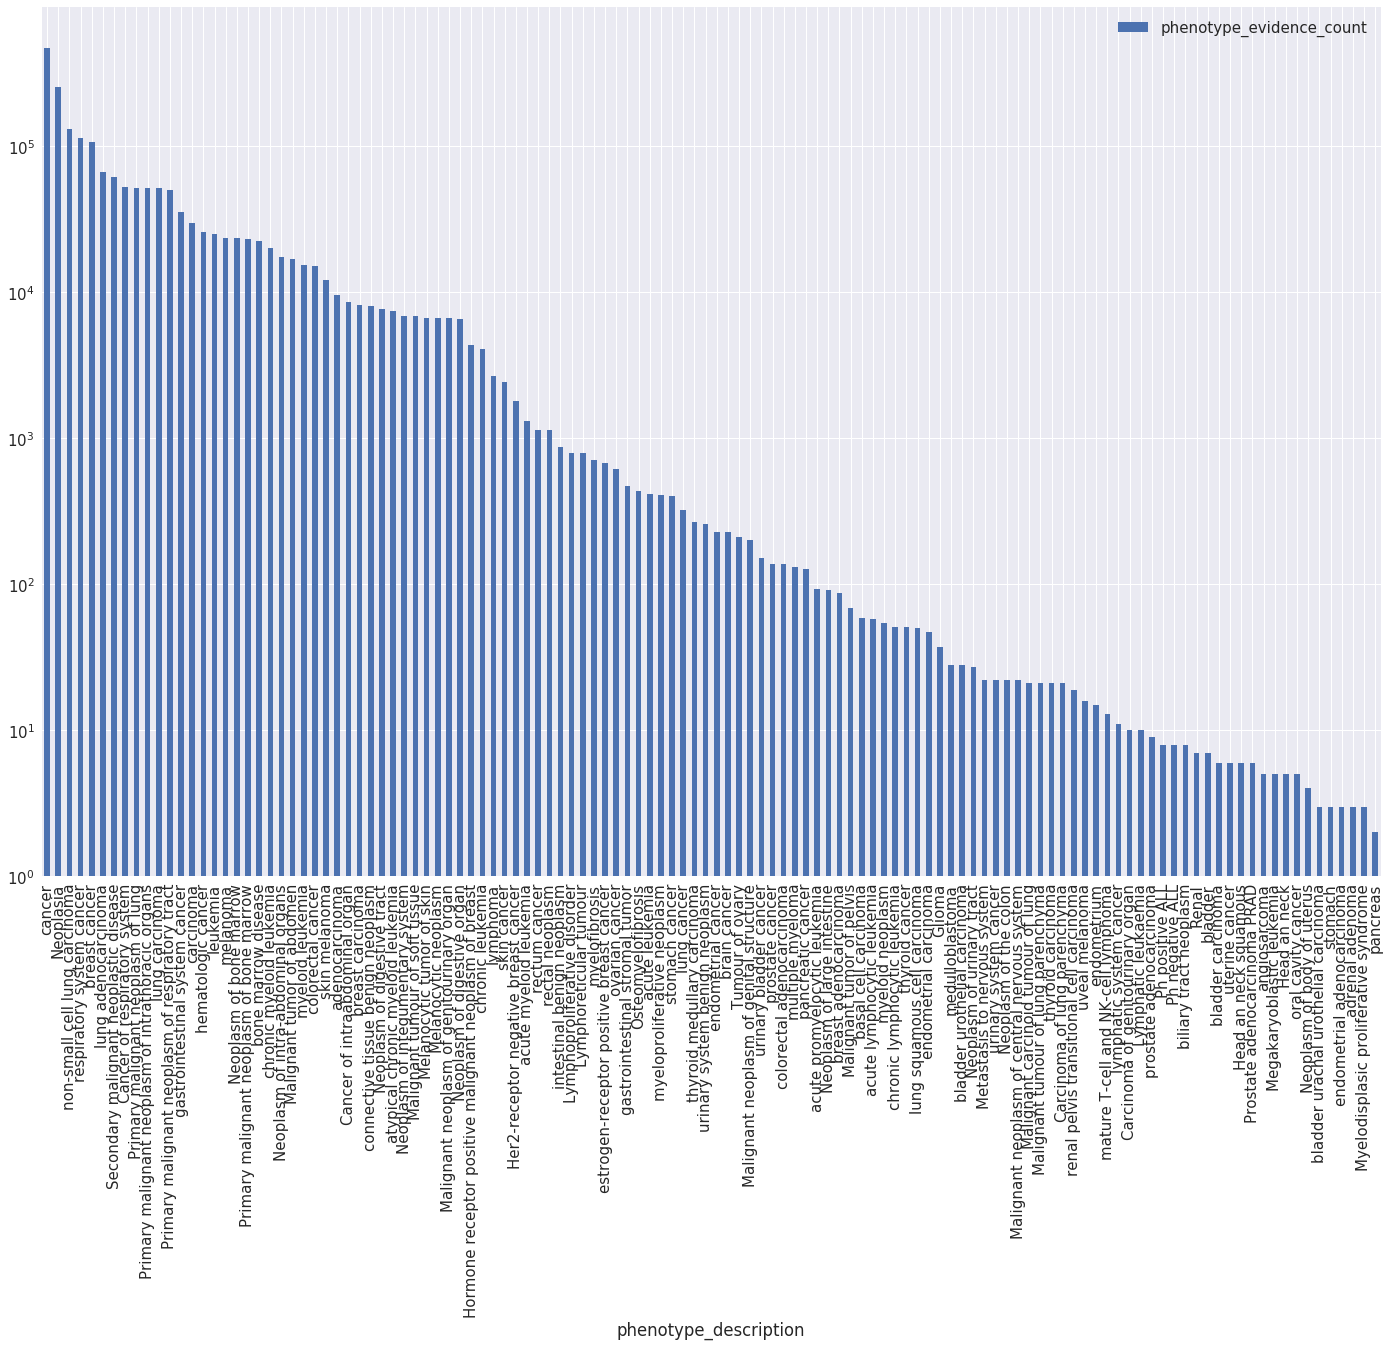

In [30]:
sns.set(font_scale=1.5)
cgi_phenotypes_summary.plot(kind='bar', log=True,  figsize=(24, 16))